## daily data updates for the helioforecast.space website of science data

Main author: C. Möstl, Austrian Space Weather Office, GeoSphere Austria

https://github.com/cmoestl/heliocats

uses environment 'envs/env_helio4.yml'

need to copy kernel files manually to the kernel paths


In [15]:
# https://github.com/cmoestl/heliocats  data_update_web_science.py

# for updating data every day on the servers

import pickle
import importlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import sys
import numpy as np
import datetime
import scipy.signal
import glob
import urllib
from urllib.request import urlopen
import json
import os   
import time
import h5py
import pytz
import copy
import cdflib
import pandas as pd
from datetime import datetime, timedelta
import spiceypy
import glob
import urllib.request
import json
from bs4 import BeautifulSoup 
import astrospice
from sunpy.coordinates import HeliocentricInertial, HeliographicStonyhurst


from heliocats import data as hd
from heliocats import plot as hp


##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    matplotlib.use('Agg') 
#mac
if sys.platform =='darwin':  
    print('system is mac')
    #for testing
    %matplotlib inline     
    #matplotlib.use('Agg') 



################################################ CHECK  ##############################################
os.system('jupyter nbconvert --to script data_update_web_science.ipynb')   


#import warnings
#warnings.filterwarnings("ignore")

#switches
debug_mode=0


#switches
get_psp=0
get_solo=1

get_wind=0
get_stereoa=0
get_bepi=0
####################################################################################################################


#test execution times
t0all = time.time()

system is mac


[NbConvertApp] Converting notebook data_update_web_science.ipynb to script
[NbConvertApp] Writing 19472 bytes to data_update_web_science.py


### Configure paths depending on server or local machine


In [2]:
if sys.platform == 'linux': 
    
    from config_server import data_path
    from config_server import noaa_path
    from config_server import wind_path
    from config_server import solo_path    
    from config_server import psp_path 
    from config_server import stereoa_path
    from config_server import kernels_path
    from config_server import data_path_ml
    
if sys.platform =='darwin':  

    from config_local import data_path
    from config_local import noaa_path
    from config_local import wind_path
    from config_local import solo_path 
    from config_local import psp_path 
    from config_local import stereoa_path
    from config_local import kernels_path 
    from config_local import data_path_ml

print(' ')
print('------ PATHS ')

print(data_path)
print(noaa_path)
print(wind_path)
print(solo_path)
print(stereoa_path)
print(kernels_path)
#print(data_path_ml)


plot_path=data_path+'plots/'
position_path=data_path+'plots_positions/'
sun_path=data_path+'plots_sun/'

print(plot_path)
print(position_path)



########### make directories first time
if os.path.isdir(plot_path) == False: os.mkdir(plot_path)
if os.path.isdir(plot_path+'omni2') == False: os.mkdir(plot_path+'omni2')
if os.path.isdir(plot_path+'wind') == False: os.mkdir(plot_path+'wind')
if os.path.isdir(plot_path+'solo') == False: os.mkdir(plot_path+'solo')
if os.path.isdir(plot_path+'psp') == False: os.mkdir(plot_path+'psp')
if os.path.isdir(plot_path+'stereoa') == False: os.mkdir(plot_path+'stereoa')
if os.path.isdir(plot_path+'combined') == False: os.mkdir(plot_path+'combined')


if os.path.isdir(position_path) == False: os.mkdir(position_path)
if os.path.isdir(sun_path) == False: os.mkdir(sun_path)
if os.path.isdir(noaa_path) == False: os.mkdir(noaa_path)
if os.path.isdir(solo_path) == False: os.mkdir(solo_path)
if os.path.isdir(solo_path) == False: os.mkdir(psp_path)
if os.path.isdir(data_path_ml) == False: os.mkdir(data_path_ml)

 
------ PATHS 
/Users/chris/python/data/insitu_python/
/Users/chris/python/ops/data/noaa/
/Users/chris/python/data/wind/
/Users/chris/python/data/solo/
/Users/chris/python/data/stereoa/
/Users/chris/python/data/kernels/
/Users/chris/python/data/insitu_python/plots/
/Users/chris/python/data/insitu_python/plots_positions/


### Parker Solar Probe


In [8]:
####### -------- control parameter    
#server
start_time= datetime(2018,10,1)
#end_time= datetime(2018,10,10)
#start_time= datetime(2022,12,1)
end_time = datetime.utcnow() 
psp_file=data_path+'psp_2018_now_rtn.p'


if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

    start_time= datetime(2018,10,5)
    end_time  = datetime(2018,10,7)
    psp_file=data_path+'psp_rtn_test.p'

    
if get_psp > 0:    

    t0 = time.time()  

    print('--------------------- PSP ------------------------- ')
    print('download PSP data until today ')
    print(psp_path)

    hd.download_pspmag_1min(start_time,end_time,psp_path)
    hd.download_pspplas(start_time,end_time,psp_path)

    print('process PSP to pickle')
    hd.create_psp_pkl(start_time,end_time,psp_file,psp_path)
    #print(psph)

    t1=time.time()
    
    print(' ')
    print('PSP done in ', np.round((t1-t0)/60,2), 'minutes')
    print('----------------------------------- ')
else:
    print('PSP data NOT downloaded and pickled, turn on switch')  


  

--------------------- PSP ------------------------- 
download PSP data until today 
/Users/chris/python/data/psp/
psp_fld_l2_mag_rtn_1min_20181006_v02.cdf has already been downloaded.
psp_swp_spi_sf00_l3_mom_20181006_v04.cdf has already been downloaded.
process PSP to pickle
ERROR: list index out of range 20181005 does not exist
ERROR: list index out of range 20181005 does not exist
combine mag and plasma
get positions


Files Downloaded: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06file/s]


produce recarray
save pickle
 
PSP done in  0.06 minutes
----------------------------------- 


Science level 2 solar wind magnetic field (FIELDS) and plasma data (SWEAP/SPI/MOM) from Parker Solar Probe, obtained from https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min and https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/  Timerange: 2018-Oct-06 06:53 to 2018-Oct-07 23:59, resampled to a time resolution of 1 min. The data are available in a numpy recarray, fields can be accessed by psp.time, psp.bx, psp.vt etc. Total number of data points: 2467. Units are btxyz [nT, RTN], vtxy  [km s^-1], np[cm^-3], tp [K], heliospheric position x/y/z [km] or r/lon/lat [AU, degree, HEEQ]. Made with heliocats/data_update_web_science.ipynb, by E. Davies (twitter @spacedavies) and Christian Möstl (@chrisoutofspace). File creation date: 2023-Jul-28 09:32 UTC


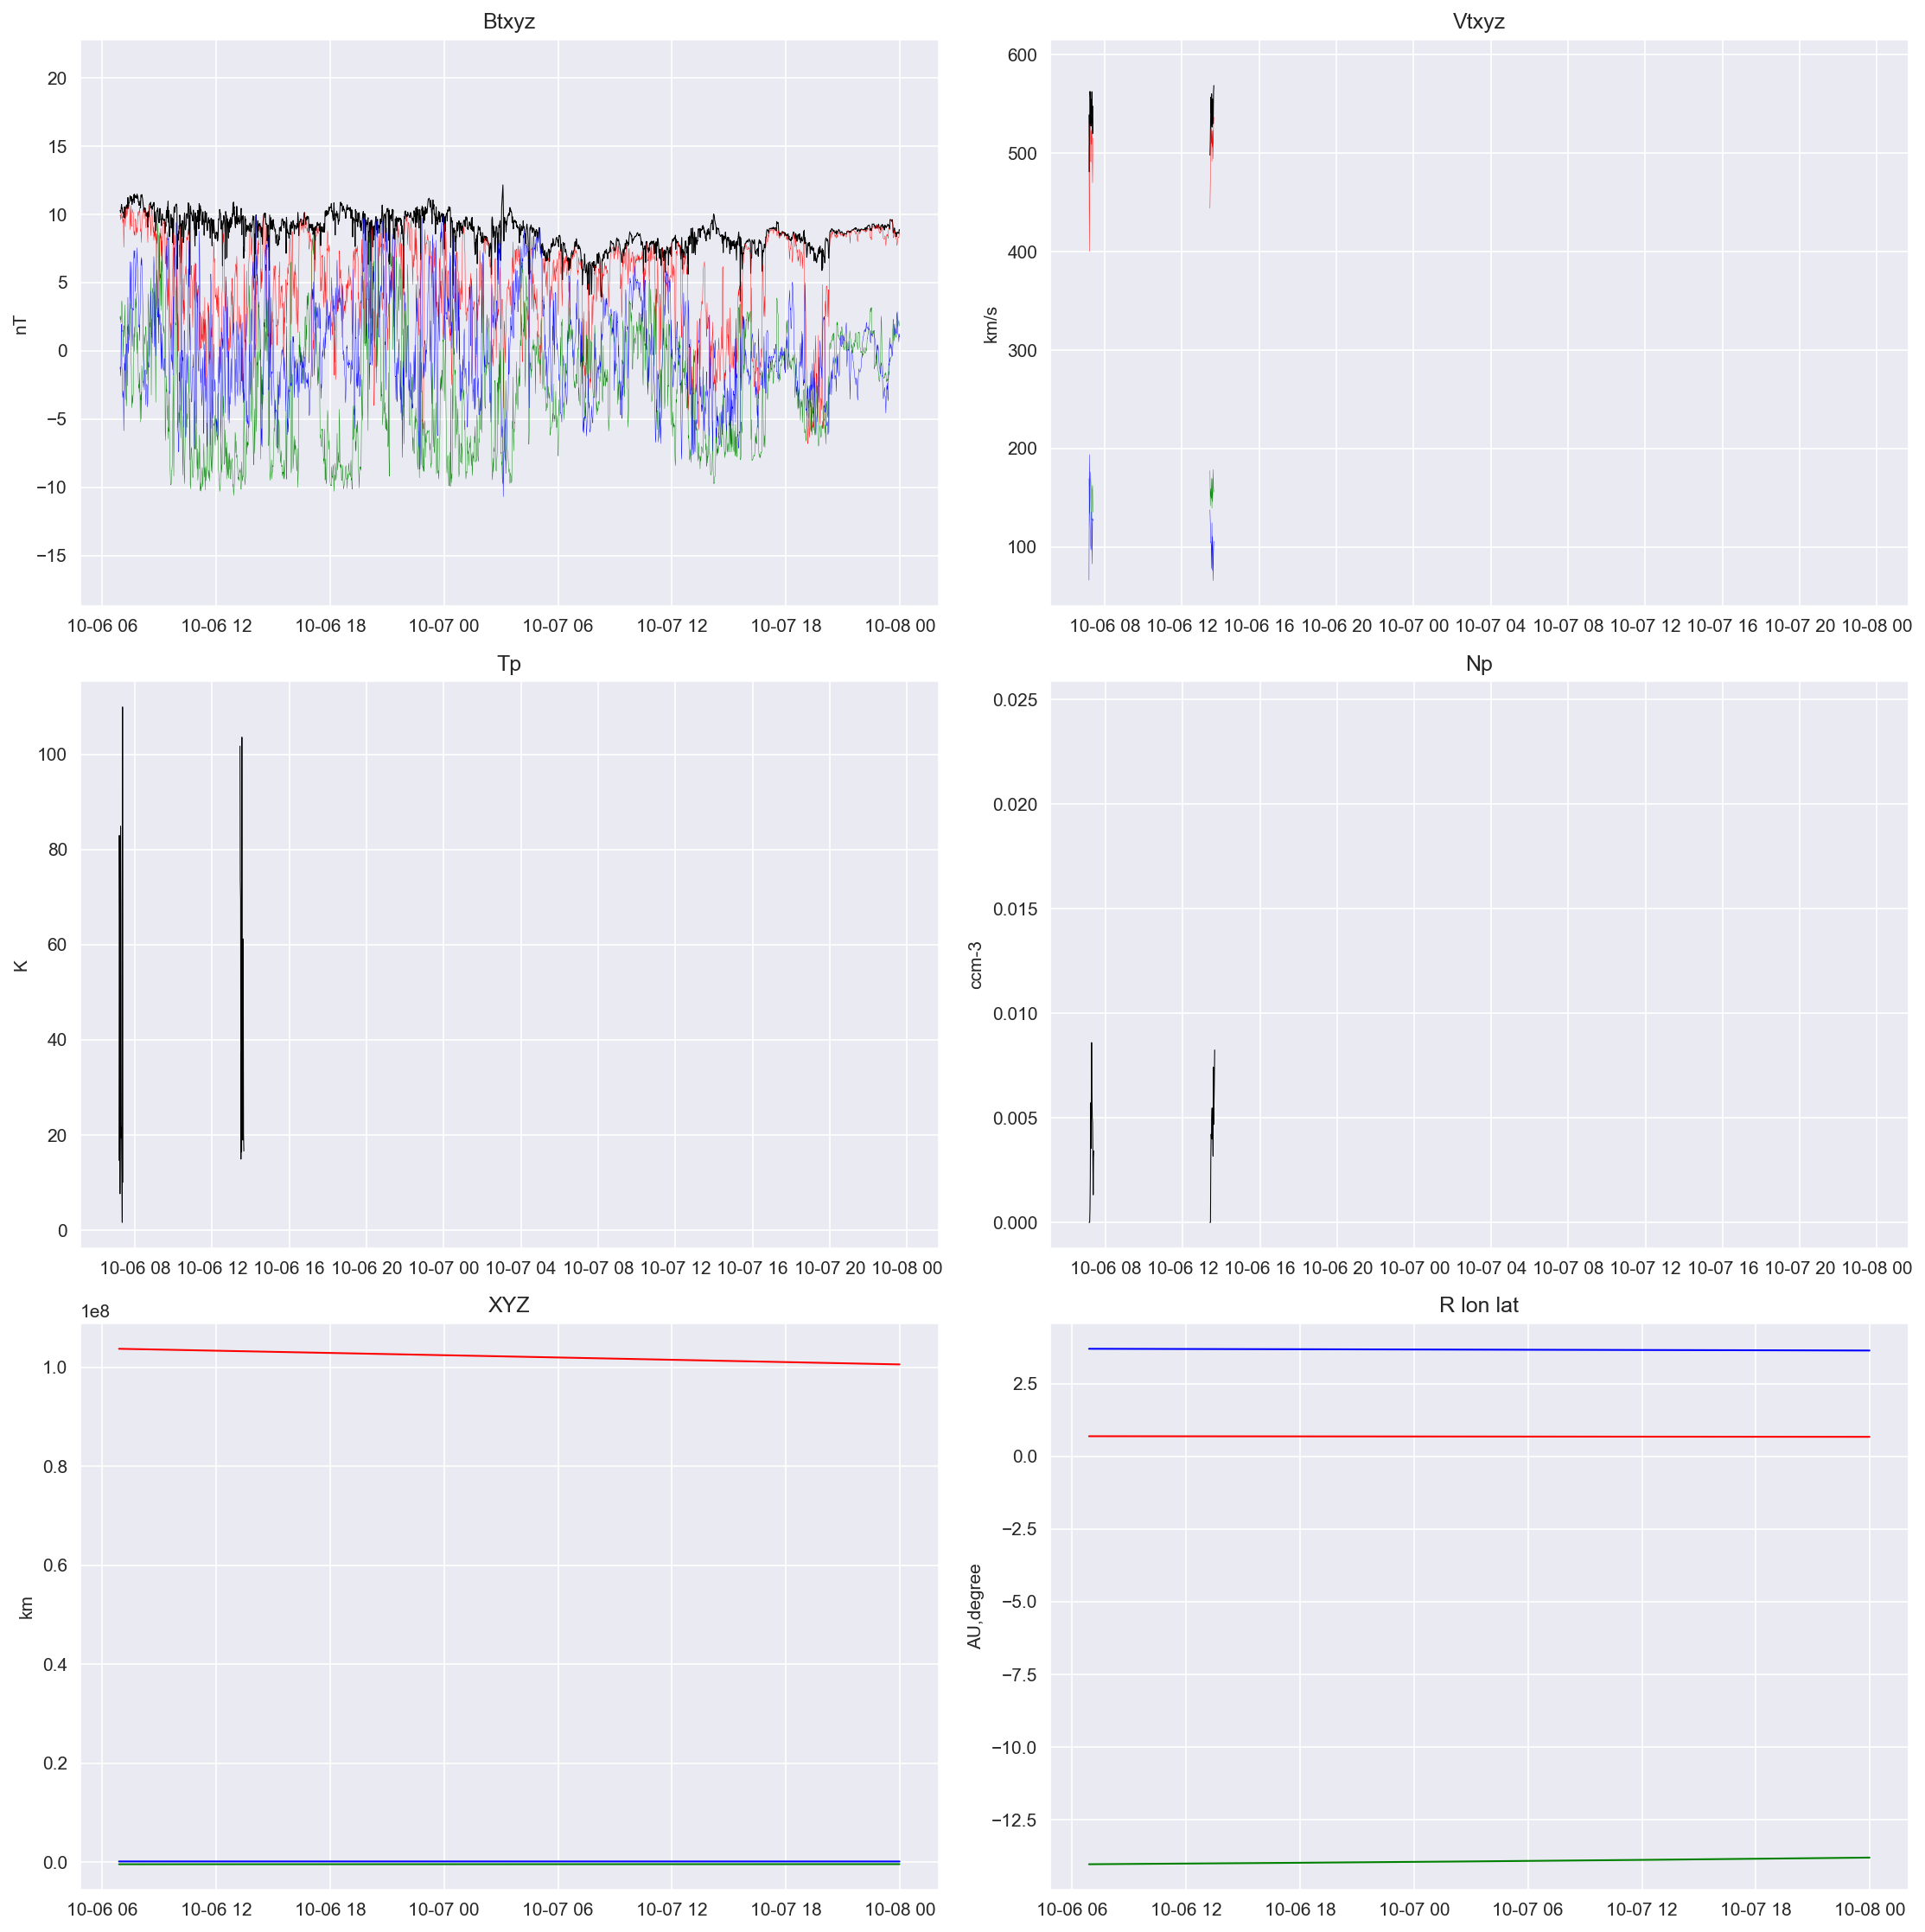

In [12]:
### data checks

filepsp='psp_2018_now_rtn.p'
if debug_mode > 0: filepsp='psp_rtn_test.p'
[data,header]=pickle.load(open(data_path+filepsp, "rb" ) )

############ print header

print(header)

########## add overview plots

hp.data_overview_plot(data,plot_path+'psp/'+filepsp[:-2])




### Solar Orbiter

In [13]:
####### -------- control parameter    

#for server
start_time= datetime(2020,4,14)
#end_time  = datetime(2020,4,20)
end_time = datetime.utcnow() 
solo_file=data_path+'solo_2020_now_rtn.p'

#testing
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 
    start_time= datetime(2022,1,25)
    end_time  = datetime(2022,2,10)
    solo_file=data_path+'solo_rtn_test.p'


if get_solo > 0:    

    t0 = time.time()  

    print('--------------------- SolO ------------------------- ')
    print('download SolO science data until today ')
    print(solo_path)

    hd.download_solomag_1min(start_time,end_time,solo_path)
    hd.download_soloplas(start_time,end_time,solo_path)

    print('process Solar Orbiter to pickle')
    hd.create_solo_pkl(start_time,end_time,solo_file,solo_path,kernels_path)
    #print(psph)

    t1=time.time()
    
    print(' ')
    print('Solo done in ', np.round((t1-t0)/60,2), 'minutes')
    print('----------------------------------- ')
else:
    print('Solo data NOT downloaded and pickled, turn on switch')  


--------------------- SolO ------------------------- 
download SolO science data until today 
/Users/chris/python/data/solo/
solo_L2_mag-rtn-normal-1-minute_20220125.cdf has already been downloaded.
solo_L2_mag-rtn-normal-1-minute_20220126.cdf has already been downloaded.
solo_L2_mag-rtn-normal-1-minute_20220127.cdf has already been downloaded.
solo_L2_mag-rtn-normal-1-minute_20220128.cdf has already been downloaded.
solo_L2_mag-rtn-normal-1-minute_20220129.cdf has already been downloaded.
solo_L2_mag-rtn-normal-1-minute_20220130.cdf has already been downloaded.
ERROR HTTP Error 404:  solo_L2_mag-rtn-normal-1-minute_20220131
ERROR HTTP Error 404:  solo_L2_mag-rtn-normal-1-minute_20220201
solo_L2_mag-rtn-normal-1-minute_20220202.cdf has already been downloaded.
solo_L2_mag-rtn-normal-1-minute_20220203.cdf has already been downloaded.
solo_L2_mag-rtn-normal-1-minute_20220204.cdf has already been downloaded.
ERROR HTTP Error 404:  solo_L2_mag-rtn-normal-1-minute_20220205
ERROR HTTP Error 

Science level 2 solar wind magnetic field (MAG) and plasma data (SWA) from Solar Orbiter, obtained from https://soar.esac.esa.int/soar/  Timerange: 2022-Jan-25 00:00 to 2022-Feb-09 23:59, resampled to a time resolution of 1 min. The data are available in a numpy recarray, fields can be accessed by solo.time, solo.bx, solo.vt etc. Total number of data points: 23040. Units are btxyz [nT, RTN], vtxy  [km s^-1], np[cm^-3], tp [K], heliospheric position x/y/z [km], r/lon/lat [AU, degree, HEEQ]. Made with heliocats/data_update_web_science.ipynb, by E. Davies (twitter @spacedavies) and Christian Möstl (@chrisoutofspace). File creation date: 2023-Jul-28 09:33 UTC


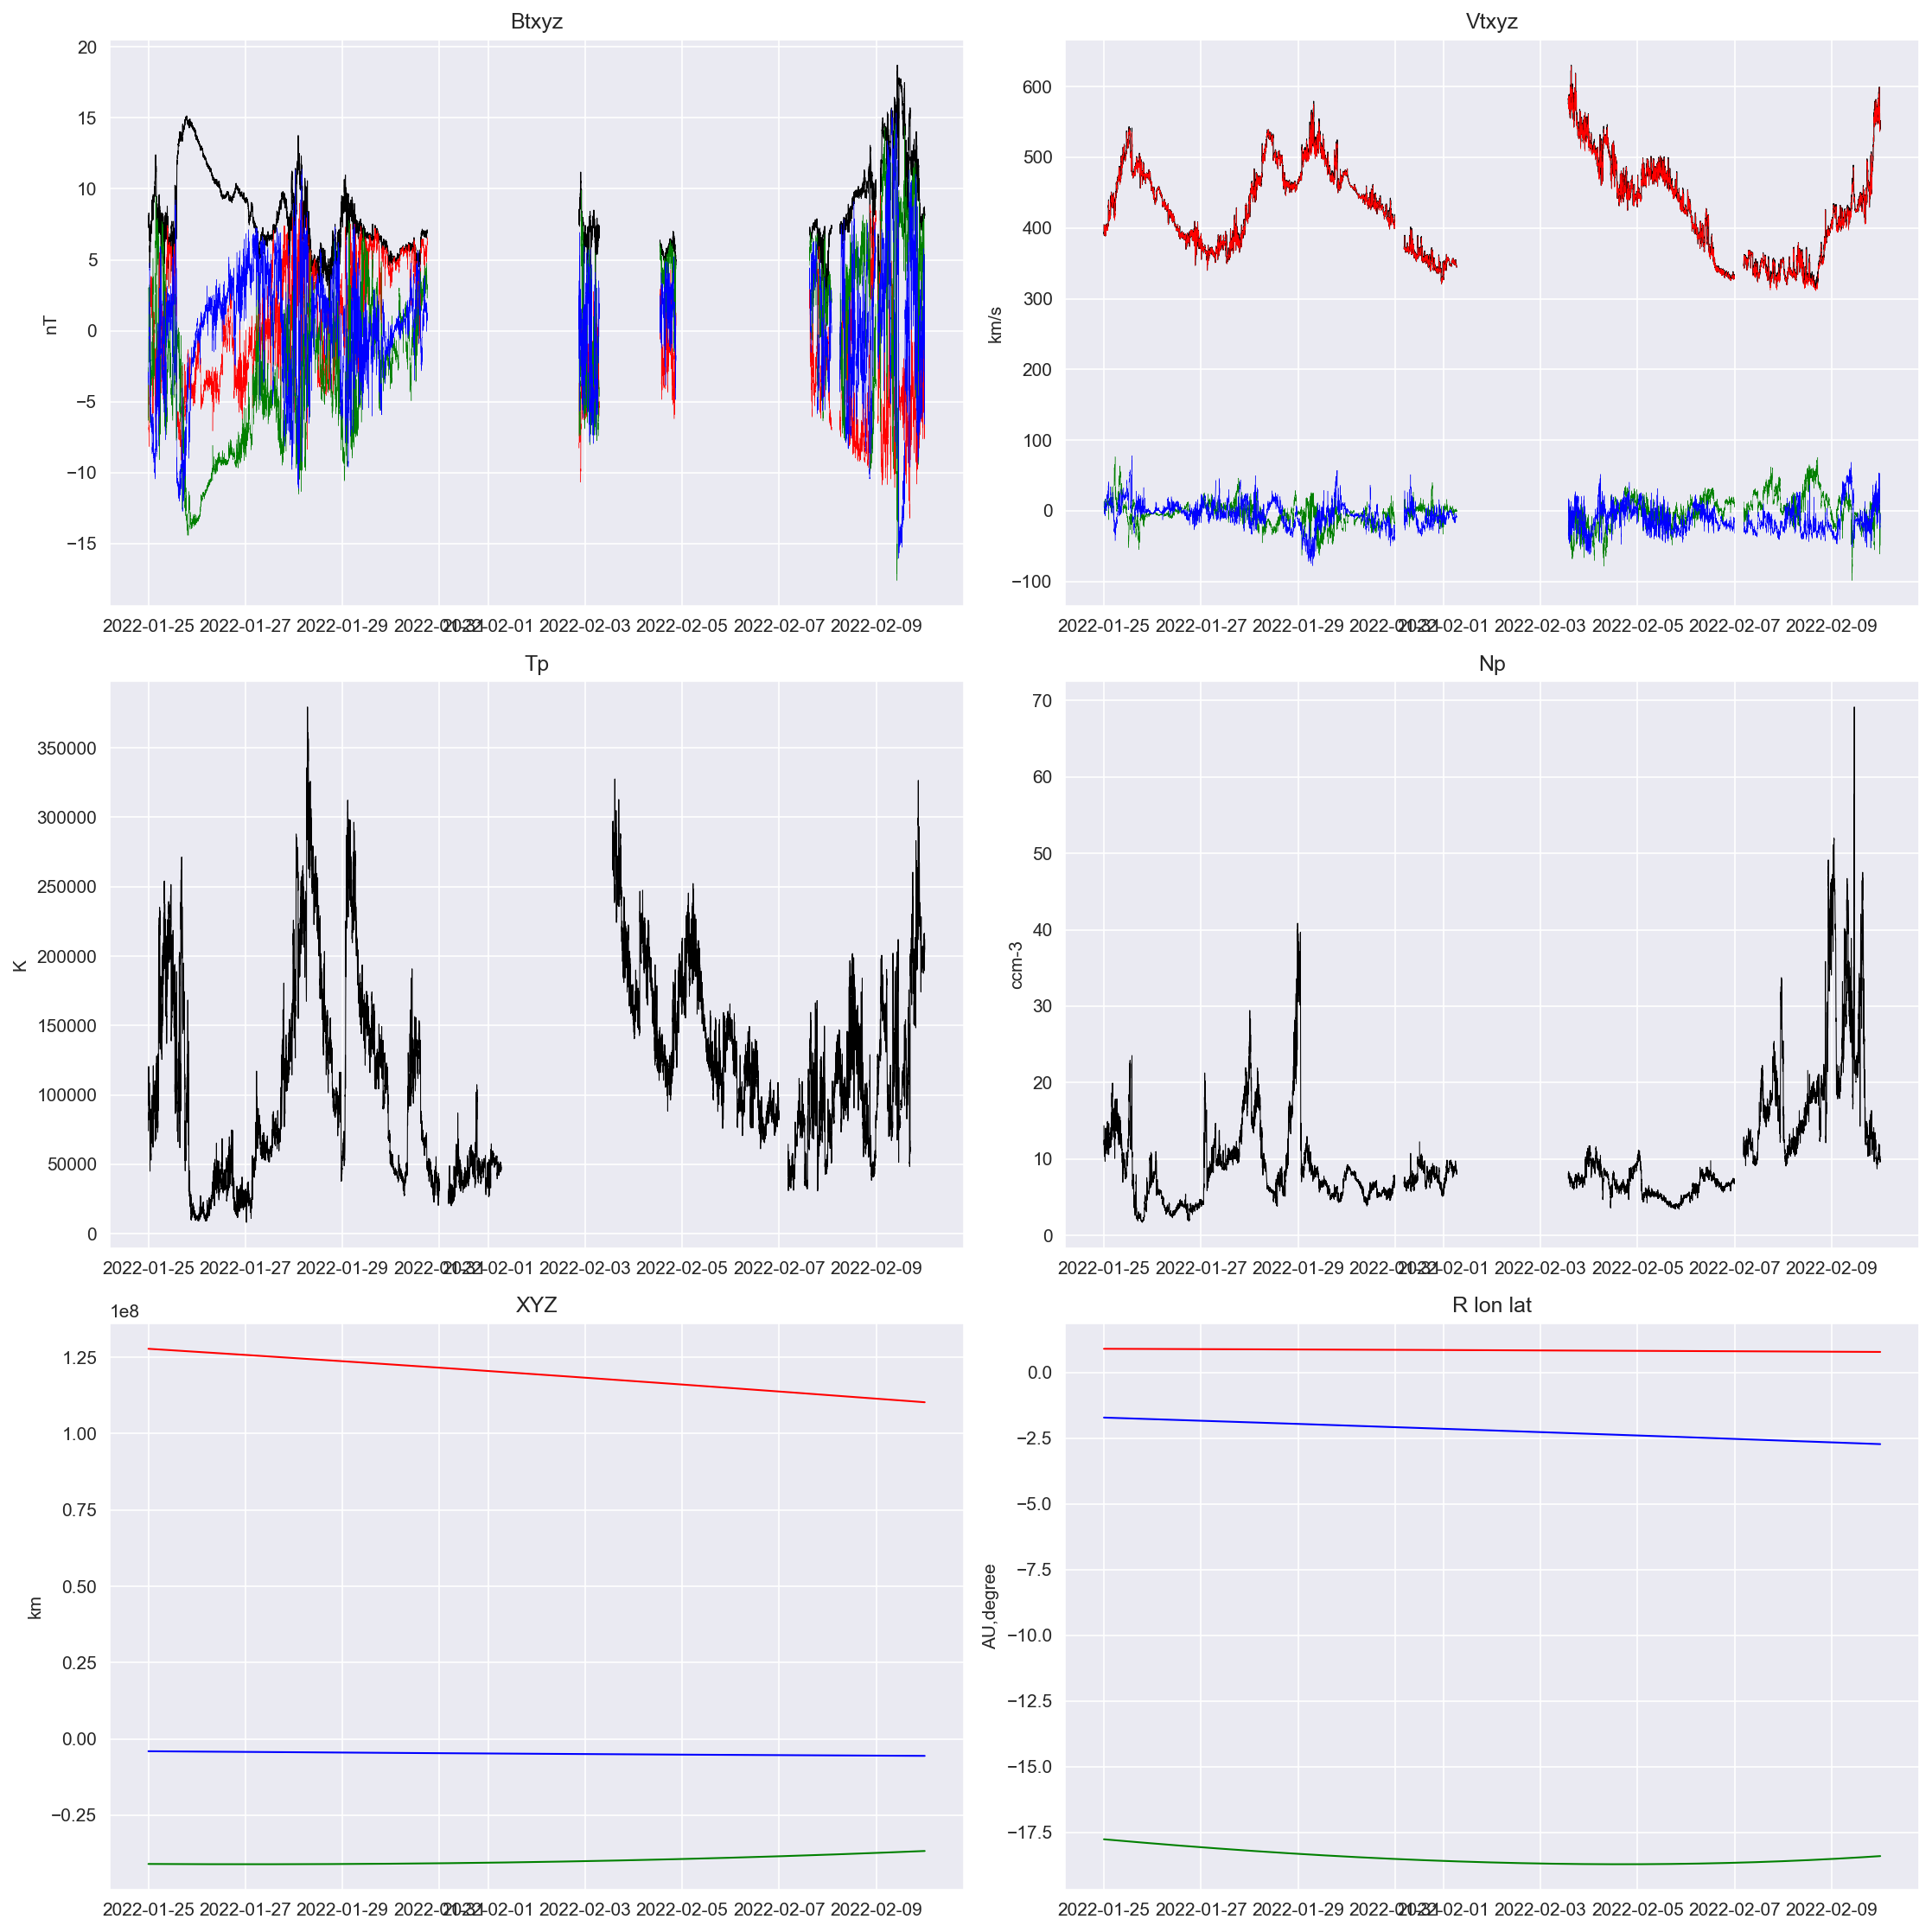

In [14]:
### data checks

filesolo='solo_2020_now_rtn.p'   

if debug_mode > 0: filesolo='solo_rtn_test.p'

[data,header]=pickle.load(open(data_path+filesolo, "rb"))
############ print header

print(header)

########## add overview plots

hp.data_overview_plot(data,plot_path+'solo/'+filesolo[:-2])


### Wind 

In [58]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 
    
print('-------------------------------- Wind -------------------------- ')
print('download Wind data ')

#download data for current year only    
if get_wind > 0:
    
    t0 = time.time() 
    
    hd.wind_download_ascii(start_year=datetime.utcnow().year, wind_path=wind_path) 

    t1=time.time()
    
    print('Wind pickle TBD')
    
    print(' ')
    print('Wind done in ', np.round((t1-t0)/60,2), 'minutes')
    print('----------------------------------- ')
    
else:
    print('Wind data NOT downloaded, turn on switch')  
    

    
#filewin="wind_2018_now_heeq.p" 
#start=datetime.datetime(2022, 12, 1)
#start=datetime.datetime(2022, 12, 1)
#end=datetime.datetime.utcnow()

#hd.save_wind_data_ascii(data_path,filewin,start,end,coord='HEEQ')
#[win,winh]=pickle.load(open(data_path+filewin, "rb"))
#start=win.time[-1]-datetime.timedelta(days=365)
#end=datetime.datetime.utcnow()         
#hp.plot_insitu_update(win, start, end,'Wind',plot_path+'wind/',now=True)


#on linux
#print('download new Wind data files without overwriting existing files')

#on mac for testing
#wind_data_path='/Users/chris/python/data/wind/wind_mfi_k0'
#os.system('curl -nc --directory-prefix='+wind_data_path+' "ftps://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_k0/2020/*.cdf"')



#wind_data_path='/perm/aswo/data/wind/wind_mfi_k0'
#print(wind_data_path)
#os.system('wget -nc --directory-prefix='+wind_data_path+' "ftps://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_k0/2020/*.cdf"')
#wind_data_path='/nas/helio/data/heliosat/data/wind_swe_h1'
#os.system('wget -nc --directory-prefix='+wind_data_path+' "ftps://spdf.gsfc.nasa.gov/pub/data/wind/swe/swe_h1/2020/*.cdf"')

#filewin="wind_2018_now_gse.p" 
##xstart=datetime.datetime(2018, 1, 1)
#end=datetime.datetime.utcnow()
#if get_new_data: hd.save_wind_data(data_path,filewin,start,end,heeq=False)
#[win,hwin]=pickle.load(open(data_path+filewin, "rb" ) )  

#filewin="wind_2018_now_heeq.p" 
#start=datetime.datetime(2018, 1, 1)
#end=datetime.datetime.utcnow()
#if get_new_data: hd.save_wind_data(data_path,filewin,start,end,heeq=True)

#start=win.time[-1]-datetime.timedelta(days=100)
#end=datetime.datetime.utcnow()         
#hp.plot_insitu_update(win, start, end,'Wind',plot_path,now=True)

-------------------------------- Wind -------------------------- 
download Wind data 
downloading Wind ascii data to  /Users/chris/python/data/wind/
for years ['2023']
https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/ascii/1min_ascii/
202301_wind_mag_1min.asc
202302_wind_mag_1min.asc
202303_wind_mag_1min.asc
202304_wind_mag_1min.asc
202305_wind_mag_1min.asc
202306_wind_mag_1min.asc
https://spdf.gsfc.nasa.gov/pub/data/wind/swe/ascii/swe_kp_unspike/
wind_kp_unspike2023.txt
Wind pickle TBD
 
Wind done in  0.25 minutes
----------------------------------- 


### BepiColombo

In [6]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 


####### -------- control parameter    
#server
#start_time= datetime(2018,12,1)
#end_time = datetime.utcnow().date() + timedelta(days=1)
#psp_file=data_path+'psp_2018_now_rtn.p'

#testing
start_time= datetime(2021,12,1)
end_time  = datetime(2021,12,5)
bepi_file=data_path+'bepi_rtn_test.p'
######### -------------------

#print(kernels_path)
#hd.solo_furnish(kernels_path)


if get_bepi > 0:    

    t0 = time.time()  

    print('--------------------- Bepi ------------------------- ')
    print('download Bepi data manually ')
    print(bepi_path)

    print('process Bepi Orbiter to pickle')
    #hd.create_solo_pkl(start_time,end_time,solo_file,solo_path,kernels_path)
    #print(psph)

    t1=time.time()
    
    print(' ')
    print('Bepi done in ', np.round((t1-t0)/60,2), 'minutes')
    print('----------------------------------- ')
else:
    print('Bepi data NOT downloaded and pickled, turn on switch')  

#solo=pickle.load(open(data_path+'solo_rtn_test.p', "rb"))
#plt.plot(solo.time,solo.bt)


Bepi data NOT downloaded and pickled, turn on switch


### STEREO-A science data

In [7]:

"""
STEREO-A SERVER DATA PATH
"""

stereoa_path='/perm/aswo/data/stereoa/'

"""
DOWNLOAD STEREOA DATA FUNCTIONS: MERGED 1MIN IMPACT
"""

def download_stereoa_merged(start_timestamp, end_timestamp=datetime.utcnow(), path=stereoa_path+'impact/merged/level2/'):
    start = start_timestamp.year
    end = end_timestamp.year + 1
    while start < end:
        year = start
        date_str = f'{year}0101'
        try: 
            data_url = f'https://spdf.gsfc.nasa.gov/pub/data/stereo/ahead/l2/impact/magplasma/1min/{year}/'
            soup = BeautifulSoup(urlopen(data_url), 'html.parser')
            for link in soup.find_all('a'):
                href = link.get('href')
                if href is not None and href.startswith('sta_l2_magplasma_1m_'+date_str):
                    filename = href
                    if os.path.isfile(f"{path}{filename}") == True:
                        print(f'{filename} has already been downloaded.')
                    else:
                        urllib.request.urlretrieve(data_url+filename, f"{path}{filename}")
                        print(f'Successfully downloaded {filename}')
        except Exception as e:
            print('ERROR', e, f'.File for {year} does not exist.')
        start+=1


"""
LOAD IN STEREOA DATA FUNCTIONS: from datapath, and arranges into large dataframes for timerange
"""


def get_stereoa_merged(fp):
    """raw = rtn"""
    try:
        cdf = cdflib.CDF(fp)
        t1 = cdflib.cdfepoch.to_datetime(cdf.varget('Epoch'))
        df = pd.DataFrame(t1, columns=['time'])
        bx, by, bz = cdf['BFIELDRTN'][:].T
        df['bx'] = bx
        df['by'] = by
        df['bz'] = bz
        df['bt'] = cdf['BTOTAL']
        df['np'] = cdf['Np']
        df['tp'] = cdf['Tp']
        df['vt'] = cdf['Vp']
        cols = ['bx', 'by', 'bz', 'bt', 'np', 'tp', 'vt']
        for col in cols:
            df[col].mask(df[col] < -9.999E29 , pd.NA, inplace=True)
        df['vx'] = cdf['Vr_Over_V_RTN']*df['vt']
        df['vy'] = cdf['Vt_Over_V_RTN']*df['vt']
        df['vz'] = cdf['Vn_Over_V_RTN']*df['vt']
        v_cols = ['vx', 'vy', 'vz']
        for v_col in v_cols:
            df[v_col].mask(df[v_col] < -9.999E29 , pd.NA, inplace=True)
    except Exception as e:
        print('ERROR:', e, fp)
        df = None
    return df


def get_stereoa_merged_range(start_timestamp, end_timestamp=datetime.utcnow(), path=stereoa_path+'impact/merged/level2/'):
    """Pass two datetime objects and grab .cdf files between dates, from
    directory given."""
    df=None
    start = start_timestamp.year
    end = datetime.utcnow().year + 1
    while start < end:
        year = start
        date_str = f'{year}0101'
        try: 
            fn = glob.glob(path+f'sta_l2_magplasma_1m_{date_str}*')[0]
            _df = get_stereoa_merged(fn)
            if _df is not None:
                if df is None:
                    df = _df.copy(deep=True)
                else:
                    df = pd.concat([df, _df])
        except Exception as e:
            print('ERROR:', e, f'{date_str} does not exist')
        start += 1
    timemask = (df['time']>=start_timestamp) & (df['time']<=end_timestamp)
    df = df[timemask]
    return df



"""
STEREOA POSITION FUNCTIONS: coord maths, call position for each timestamp using astrospice
"""


def sphere2cart(r, lat, lon):
    x = r*np.cos(lat*(np.pi/180))*np.cos(lon*(np.pi/180))
    y = r*np.cos(lat*(np.pi/180))*np.sin(lon*(np.pi/180))
    z = r*np.sin(lat*(np.pi/180))
    r_au = r/1.495978707E8
    return x.value, y.value, z.value, r_au.value


def get_stereoa_positions(time_series):
    kernels_sta = astrospice.registry.get_kernels('stereo-a', 'predict')
    frame = HeliographicStonyhurst()
    coords_sta = astrospice.generate_coords('Stereo ahead', time_series)
    coords_sta = coords_sta.transform_to(frame)
    x, y, z, r_au = sphere2cart(coords_sta.radius, coords_sta.lat, coords_sta.lon)
    lat = coords_sta.lat.value
    lon = coords_sta.lon.value
    t = [element.to_pydatetime() for element in list(time_series)]
    positions = np.array([t, x, y, z, r_au, lat, lon])
    df_positions = pd.DataFrame(positions.T, columns=['time', 'x', 'y', 'z', 'r', 'lat', 'lon'])
    return df_positions


"""
FINAL FUNCTION TO CREATE PICKLE FILE: uses all above functions to create pickle file of 
data from input timestamp to now. 
Can be read in to DataFrame using:
obj = pd.read_pickle('stereoa_rtn.p')
df = pd.DataFrame.from_records(obj)
"""


def create_stereoa_pkl(start_timestamp):

    # #download stereo-a merged magplasma data up to now 
    download_stereoa_merged(start_timestamp)

    #load in merged mag and plasma data to DataFrame, create empty DataFrame if no data
    # if empty, drop time column ready for concat
    df_magplas = get_stereoa_merged_range(start_timestamp)
    if df_magplas is None:
        print(f'STEREO A data is empty for this timerange')
        df_magplas = pd.DataFrame({'time':[], 'bt':[], 'bx':[], 'by':[], 'bz':[], 'vt':[], 'vx':[], 'vy':[], 'vz':[], 'np':[], 'tp':[]})
        df_magplas = df_magplas.drop(columns=['time'])
    else:
        df_magplas.set_index(pd.to_datetime(df_magplas['time']), inplace=True)

    #get stereoa positions for corresponding timestamps
    sta_pos = get_stereoa_positions(df_magplas['time'])
    sta_pos.set_index(pd.to_datetime(sta_pos['time']), inplace=True)
    sta_pos = sta_pos.drop(columns=['time'])

    #produce final combined DataFrame with correct ordering of columns 
    comb_df = pd.concat([df_magplas, sta_pos], axis=1)

    #produce recarray with correct datatypes
    time_stamps = comb_df['time']
    dt_lst= [element.to_pydatetime() for element in list(time_stamps)] #extract timestamps in datetime.datetime format

    stereoa=np.zeros(len(dt_lst),dtype=[('time',object),('bx', float),('by', float),('bz', float),('bt', float),\
                ('vx', float),('vy', float),('vz', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float), ('r', float),('lat', float),('lon', float)])
    stereoa = stereoa.view(np.recarray) 

    stereoa.time=dt_lst
    stereoa.bx=comb_df['bx']
    stereoa.by=comb_df['by']
    stereoa.bz=comb_df['bz']
    stereoa.bt=comb_df['bt']
    stereoa.vx=comb_df['vx']
    stereoa.vy=comb_df['vy']
    stereoa.vz=comb_df['vz']
    stereoa.vt=comb_df['vt']
    stereoa.np=comb_df['np']
    stereoa.tp=comb_df['tp']
    stereoa.x=comb_df['x']
    stereoa.y=comb_df['y']
    stereoa.z=comb_df['z']
    stereoa.r=comb_df['r']
    stereoa.lat=comb_df['lat']
    stereoa.lon=comb_df['lon']
    
    #dump to pickle file
    
    header='Science level 2 solar wind magnetic field and plasma data (IMPACT) from STEREO A, ' + \
    'obtained from https://spdf.gsfc.nasa.gov/pub/data/stereo/ahead/l2/impact/magplasma/1min/ '+ \
    'Timerange: '+stereoa.time[0].strftime("%Y-%b-%d %H:%M")+' to '+stereoa.time[-1].strftime("%Y-%b-%d %H:%M")+\
    ', with a time resolution of 1 min. '+\
    'The data are available in a numpy recarray, fields can be accessed by stereoa.time, stereoa.bx, stereoa.vt etc. '+\
    'Total number of data points: '+str(stereoa.size)+'. '+\
    'Units are btxyz [nT, RTN], vtxy  [km s^-1], np[cm^-3], tp [K], heliospheric position x/y/z/r/lon/lat [AU, degree, HEEQ]. '+\
    'Made with [...] by E. Davies (twitter @spacedavies). File creation date: '+\
    datetime.utcnow().strftime("%Y-%b-%d %H:%M")+' UTC'

    pickle.dump([stereoa,header], open(stereoa_path+'stereoa_rtn.p', "wb"))
    

In [8]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

print(' ')
print('------ STEREO-A science data  ------------------')

    
t0 = time.time()  

#if get_stereoa >0: 
#    hd.download_stereoa_science_merged()

print('------ process STEREO-A to pickle')


t1 = time.time()  

print(' ')
print('------ STEREO-A finished in ', np.round(t1-t0,2), 'seconds')  


    

 
------ STEREO-A science data  ------------------
------ process STEREO-A to pickle
 
------ STEREO-A finished in  0.0 seconds


In [9]:
t1all = time.time()

print(' ')
print(' ')
print(' ')
print('------------------')
print('Runtime for full science data update:', np.round((t1all-t0all),2), 'seconds')
print('--------------------------------------------------------------------------------------')


 
 
 
------------------
Runtime for full science data update: 32.52 seconds
--------------------------------------------------------------------------------------


In [10]:


############### write header file for daily updates
#text = open('/nas/helio/data/insitu_python/data_update_headers.txt', 'w')
#text.write('Contains headers for the data files which are updated in real time.'+'\n \n')
#text.write('File creation date:  '+datetime.datetime.utcnow().strftime("%Y-%b-%d %H:%M") +' \n \n')


#text.write('NOAA real time solar wind: '+filenoaa+'\n \n'+ hnoaa+' \n \n')
#text.write('load with: >> [noaa,hnoaa]=pickle.load(open("'+data_path+filenoaa+'", "rb"))') 
#text.write(' \n \n \n \n')

#text.write('STEREO-A beacon: '+filesta_sceq+'\n \n'+ hsta+' \n \n')
#text.write('load with: >> [sta,hsta]=pickle.load(open("'+data_path+filesta+'", "rb"))') 
#text.write(' \n \n \n \n')

#text.write('Wind: '+filewin+'\n \n'+ hwin+' \n \n')
#text.write('load with: >> [win,hwin]=pickle.load(open("'+data_path+filewin+'", "rb" ))') 
#text.write(' \n \n \n \n')


#text.write('OMNI2: '+fileomni+'\n \n'+ ho+' \n \n')
#text.write('load with: >> [o,ho]=pickle.load(open("'+data_path+fileomni+'", "rb" ))') 
#text.write(' \n \n \n \n')

#text.close()